In [1]:
import torch
import pickle
import os
from tqdm import tqdm
from model import Vocaburary, TextGCN
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

c:\Users\Wen2Tee5\Desktop\Postgraduate\final\finalEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCH = 300
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
dir_name = dataset_names['20NewsGroup']
dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict.gh')
dict_data.keys()
SAVE_PATH = f'./result/{dir_name}_TrainingPercentages.result'

In [3]:
if not os.path.exists(SAVE_PATH):
    voc : Vocaburary = dict_data['voc']
    whole_graph = dict_data['whole_graph']
    word_num = dict_data['W']
    label_num = dict_data['L']
    doc_num = dict_data['D']
    train_mask = dict_data['train_mask']
    doc_Y : torch.Tensor = dict_data['doc_Y']
    word_Y : torch.Tensor = dict_data['word_Y'].T
    label_Y : torch.Tensor = dict_data['label_Y']
    train_words = list(dict_data['train_word'])
    test_words = list(dict_data['test_word'])
    train_words.sort()
    test_words.sort()

    train_num = train_mask.count_nonzero().item()
    test_num = train_mask.shape[0] - train_num

    training_percentages = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
    percentage_mask_map = {}
    for training_percentage in training_percentages:
        patial_train_num = int(train_num * training_percentage)
        temp_train_mask = [True if i < patial_train_num else False for i in range(train_num + test_num)]
        percentage_mask_map[training_percentage] = torch.tensor(temp_train_mask, dtype=torch.bool)

    result = {"TrainingPercentage" : [], "Accuracy" : []}
    doc_Y : torch.Tensor = doc_Y.cuda() 
    word_Y : torch.Tensor = word_Y.cuda()
    label_Y : torch.Tensor = label_Y.cuda()
    whole_graph : torch.sparse_coo = whole_graph.cuda()
    for training_percentage, train_mask in percentage_mask_map.items():
        train_mask = train_mask.cuda()
        log = {"ACC": [], "LOSS": []}
        model = TextGCN(whole_graph.shape[0], 200, label_num).cuda()
        optim = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss()
        trainingProcess = tqdm(range(EPOCH), desc=f"Current Percentage = {training_percentage}")
        for epoch in trainingProcess:
            total_loss = 0.
            optim.zero_grad()
            y_hat = model(whole_graph)
            doc_Y_hat = y_hat[:doc_num]
            word_Y_hat = y_hat[doc_num:-label_num]
            label_Y_hat = y_hat[doc_num+word_num :]
            doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
            word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
            label_loss = loss_fn(label_Y_hat, label_Y)
            loss = 1.0 * doc_loss + 1.0 * word_loss  + 1. * label_loss
            loss.backward()
            optim.step()
            loss_val = loss.item()
            with torch.no_grad():
                acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
            trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
            log['ACC'].append(acc_val)
            log["LOSS"].append(loss_val)
        result['TrainingPercentage'].append(training_percentage)
        result['Accuracy'].append(max(log['ACC']))
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(result, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        result = pickle.load(f)

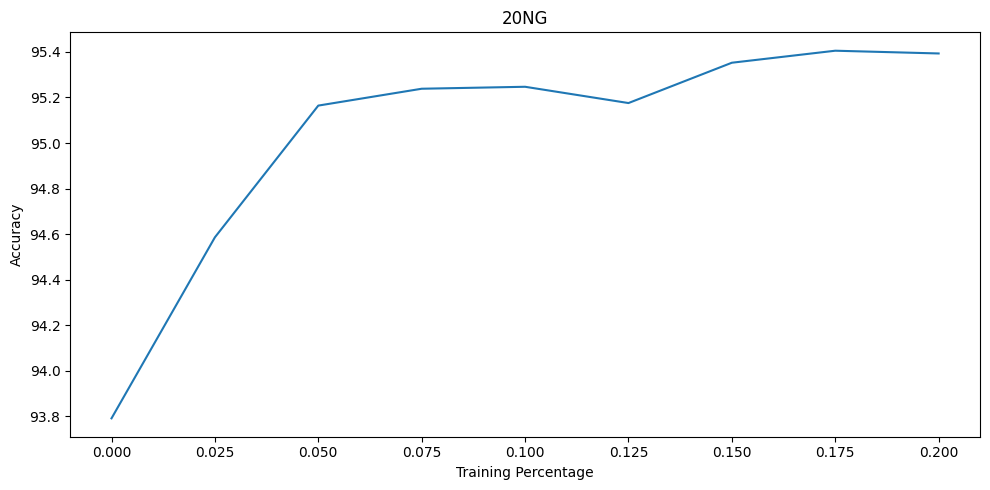

In [4]:
fig : Figure = plt.figure(figsize=(10.,5.))
plt.plot(result['TrainingPercentage'], list(map(lambda x : x * 100, result['Accuracy'])))
plt.title(f"{dir_name}")
plt.xlabel("Training Percentage")
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()
fig.savefig('./result/TrainingPercentage.svg', transparent=True, format ='svg')

In [5]:
if not os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(result, f)